In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# SHOT GUN APPROACH FOR **WHITE NOISE**
상호 독립이며, 무작위로 발생하는 randomness/불확실성을 알려주는 변수?
- **최대한의 feature engineering**
    - 일단 많이 만들고 나중에 좋은 변수만 선택 (feature selection, 차원축소, ...)
- minor features로부터 +@ 패턴 찾아보기
- 결측 여부(color, carrier, productline)
    - 시간이나 모델에 대한 어떤 정보를 주고 있을까?

In [2]:
df = pd.read_csv('./data/galaxy.csv')
df.head()

,BuyItNow,startprice,carrier,color,productline,noDescription,charCountDescription,upperCaseDescription,sold
0,0,199.99,None,White,Galaxy_S9,contains description,0,0,1
1,0,235.00,None,NaN,Galaxy_Note9,contains description,0,0,0
2,0,199.99,NaN,NaN,Unknown,no description,100,2,0
3,1,175.00,AT&T,Space Gray,Galaxy_Note9,contains description,0,0,1
4,1,100.00,None,Space Gray,Galaxy_S8,contains description,0,0,1


# 시간에 대한 정보 = index
- 데이터가 시간 순으로 수집되었다고 가정해보자.
    - 정확한 시간 간격 등은 표현하지 못하지만, **순서(order)에 대한 정보**를 가지고 있다
- 상관계수(pearson-r) > BuyItNow, sold와 -0.2에 가까운 상관성

<AxesSubplot:>

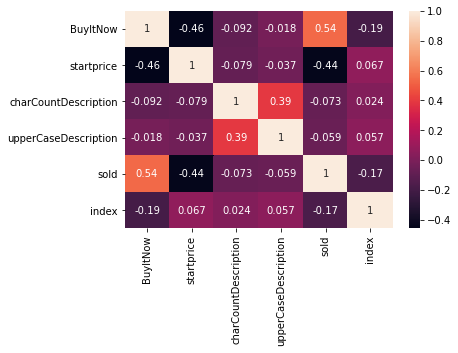

In [3]:
df['index'] = df.index
sns.heatmap(df.corr(), annot=True)

<AxesSubplot:xlabel='index', ylabel='Count'>

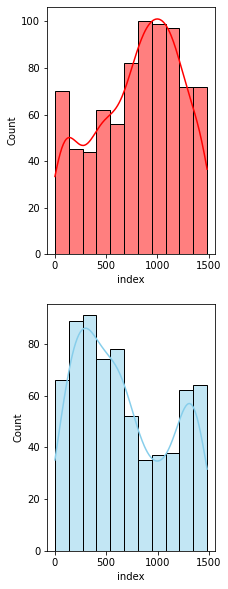

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(3,10))
sns.histplot(df[df['sold']==0]['index'], ax=axes[0], color='red', kde=True)
sns.histplot(df[df['sold']==1]['index'], ax=axes[1], color='skyblue', kde=True)

<AxesSubplot:xlabel='index', ylabel='Count'>

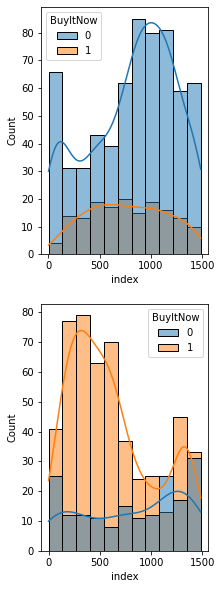

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(3,10))
sns.histplot(x='index', data=df[df['sold']==0], hue='BuyItNow',ax=axes[0], color='red', kde=True)
sns.histplot(x='index', data=df[df['sold']==1], hue='BuyItNow', ax=axes[1], color='skyblue', kde=True)

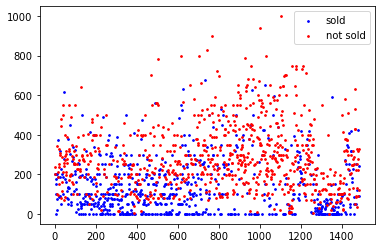

In [6]:
plt.scatter(df[df['sold']==1]['index'], df[df['sold']==1]['startprice'], s=3, c='b')
plt.scatter(df[df['sold']==0]['index'], df[df['sold']==0]['startprice'],
           c='red', s=3)
plt.legend(['sold', 'not sold'])

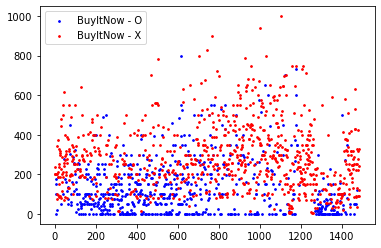

In [7]:
plt.scatter(df[df['BuyItNow']==1]['index'], df[df['BuyItNow']==1]['startprice'], s=3, c='b')
plt.scatter(df[df['BuyItNow']==0]['index'], df[df['BuyItNow']==0]['startprice'],
           c='red', s=3)
plt.legend(['BuyItNow - O', 'BuyItNow - X'])

In [8]:
df.groupby(['BuyItNow', 'sold'])['startprice'].mean()

BuyItNow  sold
0         0       301.563928
          1       240.149944
1         0       233.271937
          1        96.654596
Name: startprice, dtype: float64

In [9]:
df.groupby(['BuyItNow', 'sold'])['startprice'].std()

BuyItNow  sold
0         0       170.600174
          1       144.437882
1         0       154.668555
          1       110.902089
Name: startprice, dtype: float64

### `(BuyItNow=0, sold=1)` =? `(BuyItNow=1, sold=0)`
- `startprice` 만으로는 구별하기 힘들다

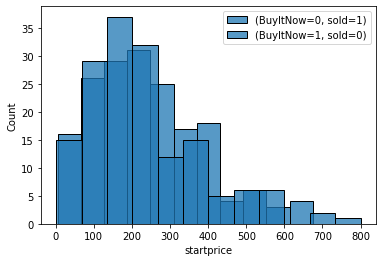

In [10]:
sns.histplot(df[(df['BuyItNow']==0) & (df['sold']==1)]['startprice'])
sns.histplot(df[(df['BuyItNow']==1) & (df['sold']==0)]['startprice'])
plt.legend(['(BuyItNow=0, sold=1)', '(BuyItNow=1, sold=0)'])

# groupby Major features

- 핵심 변수(BuyItNow, startprice, productline) 조건이 비슷할 때, 팔린 것 vs. 팔리지 않은 것 간의 차이를 설명해 줄 수 있는가?

In [11]:
BIN_unique_conditions = [df['BuyItNow']==unq for unq in df['BuyItNow'].unique()]
pd_unique_conditions = [df['productline']==unq for unq in df['productline'].unique()]
sold_unique_conditions = [df['sold']==unq for unq in df['sold'].unique()]

### (BuyItNow=0)일 때, model / sold 에 따른 startprice
- 안팔린 게 팔린 것보다 훨씬 많다
- 분포의 차이를 구분하기 힘들다

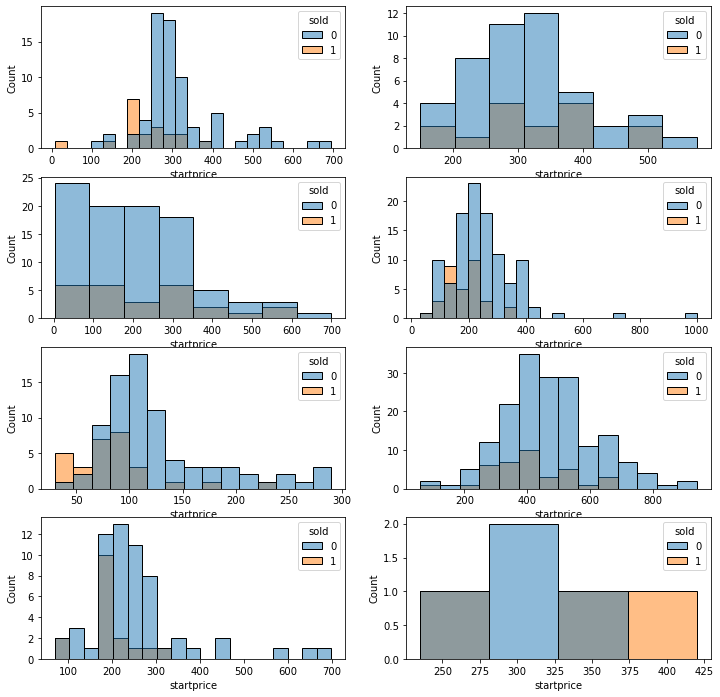

In [12]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12,12))
for i, pdcond in enumerate(pd_unique_conditions):
    r_idx = int(i/2)
    c_idx = int(i%8)%2
    #print(r_idx, c_idx)
    sns.histplot(x='startprice',
                 data=df[(df['BuyItNow']==0) & pdcond],
                 hue='sold',
                ax=axes[r_idx][c_idx])

#df_bin0_pd0 = df[BIN_unique_conditions[0] & pd_unique_conditions[0]]

### (BuyItNow=1)일 때, model / sold 에 따른 startprice
- 팔린 게 안팔린 것보다 훨씬 많다
- 분포의 차이가 상대적으로 뚜렷하다
    - 그럼에도 불구하고 상당부분이 중복된다

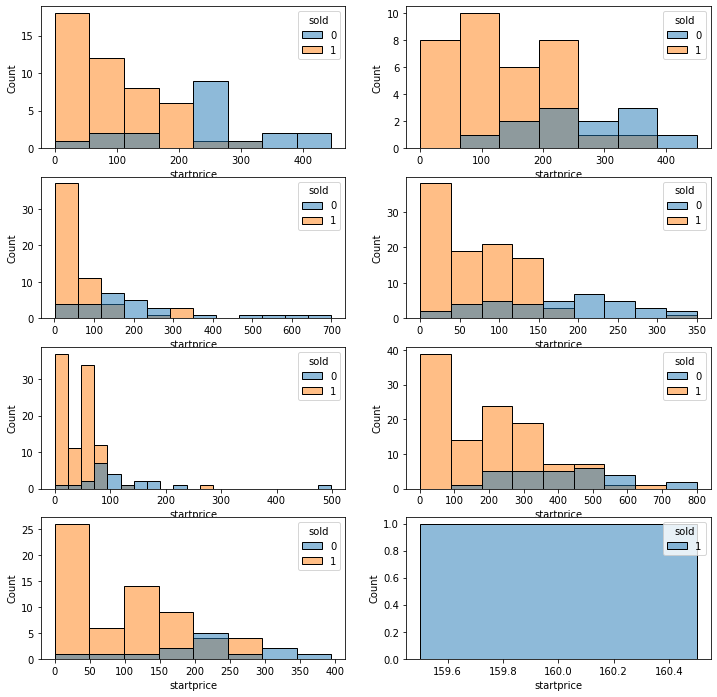

In [13]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12,12))
for i, pdcond in enumerate(pd_unique_conditions):
    r_idx = int(i/2)
    c_idx = int(i%8)%2
    #print(r_idx, c_idx)
    sns.histplot(x='startprice',
                 data=df[(df['BuyItNow']==1) & pdcond],
                 hue='sold',
                ax=axes[r_idx][c_idx])

#df_bin0_pd0 = df[BIN_unique_conditions[0] & pd_unique_conditions[0]]

# Randomness / Noise를 가능한 뚜렷하게, 구분 가능하게 해 보자
# 기본 방향성 > 최대한의 주변 정보를 살리고, 나중에 추려내자 (PCA 등)
- color
- carrier
- productline
- noDescription
- charCountDescription
- upperCaseDescription
- index

In [14]:
df.columns

Index(['BuyItNow', 'startprice', 'carrier', 'color', 'productline',
       'noDescription', 'charCountDescription', 'upperCaseDescription', 'sold',
       'index'],
      dtype='object')

# df.color
- 신뢰하기 어려운 정보 (공식 자료 등 확인 시, 불일치하는 데이터 많음)
- 색깔이 아니라, randomness에 초점을 맞춰보자
    - human error 측면에서는 매우 풍부한(?) randomness를 지님
        - 삼성 갤럭시는 space gray라는 색깔을 낸 적이 없음 (!)
        - 사람들은 Black 색상에 대해서만 시그니쳐 컬러 네임을 기억하여 사용했음
            - 셀러 입장에서 굳이 풀네임을 언급하는 게 갬성을 자극한다고 판단한 걸까?
        - 약 40%가 NaN값
            - 왜 이렇게 결측치가 많을까?
            - 핸드폰의 색상은 일반적으로 후면 커버의 색상을 의미
            - 부서졌거나 하여 부품용으로 파는 핸드폰?

In [15]:
df.color.unique()

array(['White', nan, 'Space Gray', 'Midnight Black', 'Aura Black', 'Gold',
       'Black', 'Prism Black'], dtype=object)

In [16]:
df.color.isna().sum()/len(df)

0.3993265993265993

### df.color - 결측 vs. 결측X

In [17]:
df['color_NaN'] = df['color'].apply(lambda x: 1 if type(x)!=str else 0)

In [18]:
# 색상이 기재된 핸드폰, 892개
df[df['color_NaN']==0]['productline'].value_counts()

Galaxy_Note10    232
Galaxy_S8        152
Galaxy_S7        135
Galaxy_Note8     105
Galaxy_S9         98
Unknown           88
Galaxy_Note9      74
Galaxy_S10         8
Name: productline, dtype: int64

In [19]:
df[df['color_NaN']==0]['startprice'].mean()

229.6214013452915

<AxesSubplot:xlabel='startprice', ylabel='Count'>

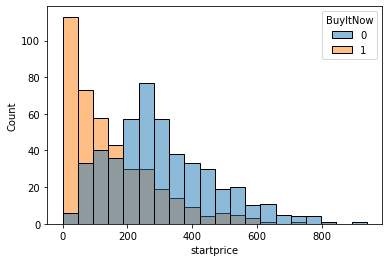

In [20]:
sns.histplot(x='startprice', data=df[df['color_NaN']==0], hue='BuyItNow')

In [21]:
# 색상이 기재되지 않은 핸드폰, 593개
df[df['color_NaN']==1]['productline'].value_counts()

Galaxy_S8        125
Galaxy_Note10    119
Unknown          116
Galaxy_S7         92
Galaxy_S9         60
Galaxy_Note8      48
Galaxy_Note9      33
Name: productline, dtype: int64

In [22]:
df[df['color_NaN']==1]['startprice'].mean()

197.62443507588532

<AxesSubplot:xlabel='startprice', ylabel='Count'>

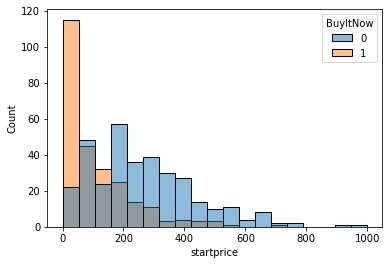

In [23]:
sns.histplot(x='startprice', data=df[df['color_NaN']==1], hue='BuyItNow')

### df.color - gamsung vs. no gamsung
40%를 차지하는 NaN이 모두 no gamsung으로 분류되는 건 좀 슬픔.
- gamsung
    - 474개
    - 50.6% 확률로 낙찰 성공
- no gamsung
    - 1011개
    - 44.1% 확률로 낙찰 성공

In [24]:
df.color.unique()

array(['White', nan, 'Space Gray', 'Midnight Black', 'Aura Black', 'Gold',
       'Black', 'Prism Black'], dtype=object)

In [25]:
df['color_sentiment'] = df['color'].apply(lambda x: 1 if x in ['Space Gray', 'Midnight Black',
                                      'Aura Black', 'Prism Black'] else 0)

In [26]:
df.groupby('color_sentiment')['startprice'].mean()

color_sentiment
0    223.489050
1    202.671203
Name: startprice, dtype: float64

In [27]:
len(df[df['color_sentiment']==1]), len(df[df['color_sentiment']==0])

(474, 1011)

In [28]:
df.groupby('color_sentiment')['sold'].mean()

color_sentiment
0    0.441147
1    0.506329
Name: sold, dtype: float64

In [29]:
df.groupby('color_sentiment')['BuyItNow'].mean()

color_sentiment
0    0.430267
1    0.489451
Name: BuyItNow, dtype: float64

### 갬성 색상 / 갬성 색상 아님 / NaN
- 미지의 갬성까지 정보를 살려보자
- NaN vs. Non-NaN 컬럼의 상위호환?

In [30]:
# NaN을 다시 따로 분류하면?
df['color_sentiment2'] = df['color'].apply(lambda x: 1 if x in ['Space Gray', 'Midnight Black',
                                      'Aura Black', 'Prism Black']
                                          else 0 if type(x) == str
                                         else -1)

In [31]:
df.color_sentiment2.value_counts()

-1    593
 1    474
 0    418
Name: color_sentiment2, dtype: int64

In [32]:
df.groupby('color_sentiment2')['sold'].mean()

color_sentiment2
-1    0.453626
 0    0.423445
 1    0.506329
Name: sold, dtype: float64

In [33]:
df.groupby('color_sentiment2')['BuyItNow'].mean()

color_sentiment2
-1    0.433390
 0    0.425837
 1    0.489451
Name: BuyItNow, dtype: float64

### Power China, Gold Premium?
- 그다지

In [34]:
df.groupby('color')['startprice'].mean().sort_values(ascending=False)

color
Gold              443.593846
Aura Black        319.457368
Prism Black       299.000000
Space Gray        276.767389
White             242.726768
Black             159.865263
Midnight Black    145.545000
Name: startprice, dtype: float64

In [35]:
df.groupby('color')['sold'].mean().sort_values(ascending=False)

color
Midnight Black    0.558394
Space Gray        0.450000
White             0.435976
Black             0.421053
Gold              0.346154
Aura Black        0.315789
Prism Black       0.000000
Name: sold, dtype: float64

In [36]:
df[df['color']=='Gold']['productline'].value_counts()

Galaxy_Note10    46
Unknown           4
Galaxy_Note8      1
Galaxy_S10        1
Name: productline, dtype: int64

<AxesSubplot:>

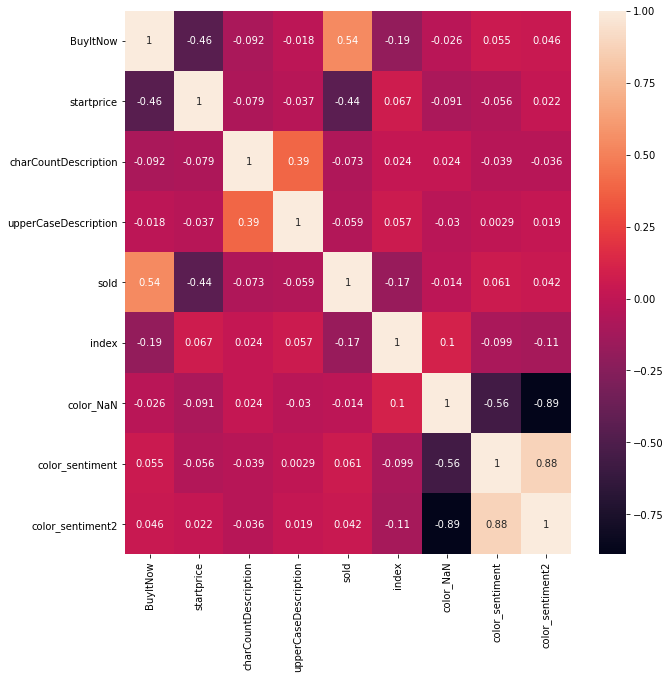

In [37]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True)

# df.carrier

In [38]:
df['carrier'].unique()

array(['None', nan, 'AT&T', 'Sprint/T-Mobile', 'Verizon'], dtype=object)

In [39]:
df['carrier_NaN'] = df['carrier'].apply(lambda x: 1 if type(x) != str else 0)
df['carrier_none'] = df['carrier'].apply(lambda x: 1 if x=='None' else -1 if type(x) != str else 0)

In [40]:
df.groupby('carrier_NaN')['startprice'].mean()

carrier_NaN
0    214.534512
1    225.743105
Name: startprice, dtype: float64

In [41]:
df.groupby('carrier_none')['startprice'].mean()

carrier_none
-1    225.743105
 0    232.693576
 1    207.885307
Name: startprice, dtype: float64

<AxesSubplot:xlabel='startprice', ylabel='Count'>

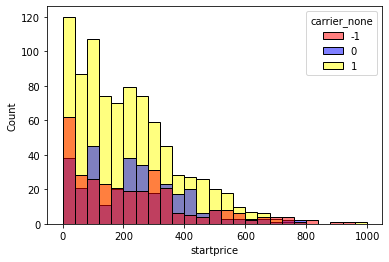

In [42]:
sns.histplot(x='startprice', data=df, hue='carrier_none', palette={-1:'red',
                                                                  0:'blue',
                                                                  1:'yellow'})

<AxesSubplot:xlabel='startprice', ylabel='Count'>

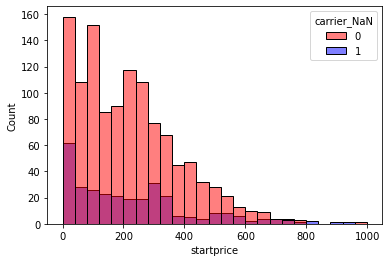

In [43]:
sns.histplot(x='startprice', data=df, hue='carrier_NaN', palette={0:'red',
                                                                  1:'blue'})

<AxesSubplot:>

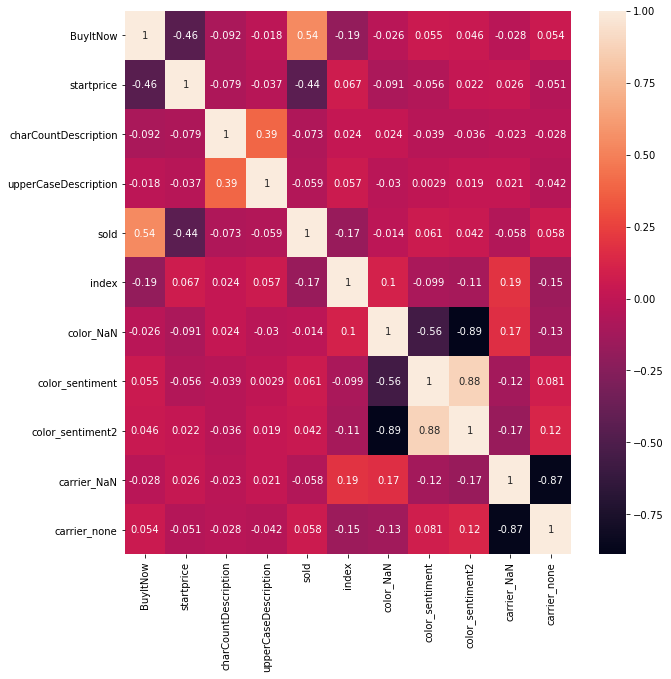

In [44]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True)

# df.productline
- **중복된 정보를 가진 컬럼**
    - 경매시점이 아닌 제품 출시 순서에 대한 정보(시간) + Note 여부 정보(모델)
    - 시간정보(ordinal)와 모델정보(binary) 두 칼럼으로 구분하기
- 'Unknown'
    1. 최대한 비슷한 카테고리 값으로 impute
    2. 그대로 사용하기

In [45]:
df.productline.unique()

array(['Galaxy_S9', 'Galaxy_Note9', 'Unknown', 'Galaxy_S8', 'Galaxy_S7',
       'Galaxy_Note10', 'Galaxy_Note8', 'Galaxy_S10'], dtype=object)

### startprice on model > 분포 비교
- Kolmogorov-Smirnov Distance
- (1st) Wasserstein Distance
- Cramer-von Mises distance
    - https://data-newbie.tistory.com/172
    - https://www.youtube.com/watch?v=U7xdiGc7IRU&feature=youtu.be

In [46]:
from scipy import stats
from scipy.stats import ks_2samp, wasserstein_distance, energy_distance

prices_of_unknown = df[df['productline']=='Unknown']['startprice']
prices_by_models = [df[df['productline']==model]['startprice'] for model in df.productline.unique()
                  if model != 'Unknown']

model_names = df.productline.unique().tolist()
model_names.remove('Unknown')

for (name, sp) in zip(model_names, prices_by_models):
    print(name)
    print(f'''
        Kolmogorov-Smirnov Distance : {ks_2samp(prices_of_unknown, sp)}
        Wasserstein Distance : {wasserstein_distance(prices_of_unknown, sp)}
        Crammer Distance : {energy_distance(prices_of_unknown, sp)}
    ''')
    print('---')
    
### S8이 startprice 분포 기준으로 가장 유사한 것으로 나타남.

Galaxy_S9

        Kolmogorov-Smirnov Distance : KstestResult(statistic=0.3277488210474063, pvalue=5.478415943116488e-09)
        Wasserstein Distance : 63.28339600397121
        Crammer Distance : 5.306616928008235
    
---
Galaxy_Note9

        Kolmogorov-Smirnov Distance : KstestResult(statistic=0.38308594465823714, pvalue=1.0124366900399195e-09)
        Wasserstein Distance : 91.14758979292652
        Crammer Distance : 6.780660799426887
    
---
Galaxy_S8

        Kolmogorov-Smirnov Distance : KstestResult(statistic=0.1234515466836554, pvalue=0.04998390093987126)
        Wasserstein Distance : 35.03334058894317
        Crammer Distance : 2.139009164130903
    
---
Galaxy_S7

        Kolmogorov-Smirnov Distance : KstestResult(statistic=0.3869525783881835, pvalue=7.105427357601002e-15)
        Wasserstein Distance : 88.96741016670985
        Crammer Distance : 6.448944354636862
    
---
Galaxy_Note10

        Kolmogorov-Smirnov Distance : KstestResult(statistic=0.4904055639349757, p

### startprice by (productline, BuyItNow, sold)

In [47]:
df.groupby(['productline', 'BuyItNow', 'sold'])['startprice'].mean()

productline    BuyItNow  sold
Galaxy_Note10  0         0       468.784540
                         1       400.213243
               1         0       416.711071
                         1       185.255179
Galaxy_Note8   0         0       258.026102
                         1       198.411765
               1         0       198.855000
                         1        88.213333
Galaxy_Note9   0         0       317.981957
                         1       325.262000
               1         0       267.911667
                         1       132.853824
Galaxy_S10     0         0       296.917500
                         1       336.333333
               1         1       160.000000
Galaxy_S7      0         0       126.981750
                         1        84.726897
               1         0       122.860000
                         1        39.506146
Galaxy_S8      0         0       248.551759
                         1       182.019697
               1         0       173.103243
  

In [48]:
bin0, bin1, sold0, sold1 = df['BuyItNow']==0, df['BuyItNow']==1, df['sold']==0, df['sold']==1

prices_of_unknown_bin0_sold0 = df[(df['productline']=='Unknown')&bin0&sold0]['startprice']
prices_of_unknown_bin0_sold1 = df[(df['productline']=='Unknown')&bin0&sold1]['startprice']
prices_of_unknown_bin1_sold0 = df[(df['productline']=='Unknown')&bin1&sold0]['startprice']
prices_of_unknown_bin1_sold1 = df[(df['productline']=='Unknown')&bin1&sold1]['startprice']
prices_of_unknowns = [prices_of_unknown_bin0_sold0,
                     prices_of_unknown_bin0_sold1,
                     prices_of_unknown_bin1_sold0,
                     prices_of_unknown_bin1_sold1]

prices_by_models = [df[df['productline']==model]['startprice'] 
                    for model in df.productline.unique()
                    if model != 'Unknown']
prices_by_models_bin_sold = [pbm[bin_&sold_] for pbm in prices_by_models
                                             for bin_ in [bin0, bin1]
                                             for sold_ in [sold0, sold1]]


model_names = df.productline.unique().tolist()
model_names.remove('Unknown')
model_names = [[mn]*4 for mn in model_names]
model_names = np.array(model_names).ravel()
postfix = ['_bin0_sold0', '_bin0_sold1', '_bin1_sold0', '_bin1_sold1']
model_names = [mn+postfix[i%4] for i, mn in enumerate(model_names)]

res_names, res_ksd, res_wd, res_cd = [], [], [], []

for i, (name, sp) in enumerate(zip(model_names, prices_by_models_bin_sold)):
    try:
        ksd = ks_2samp(prices_of_unknowns[i%4], sp).statistic
    except:
        continue # none-data has been input
    
    ksd = ks_2samp(prices_of_unknowns[i%4], sp).statistic
    wd = wasserstein_distance(prices_of_unknowns[i%4], sp)
    cd = energy_distance(prices_of_unknowns[i%4], sp)

    res_names.append(name)
    res_ksd.append(ksd)
    res_wd.append(wd)
    res_cd.append(cd)
        
#         print(name)
#         print(f'''
#             Kolmogorov-Smirnov Distance, p-value : {ksd_pval}
#             Wasserstein Distance : {wd}
#             Crammer Distance : {cd}
#         ''')
#         print('---')

In [49]:
# Cramer-von Mises distance
sorted([(n, cd) for (n, cd) in zip(res_names, res_cd)], key=(lambda x: x[1]))[:10]

[('Galaxy_S8_bin1_sold1', 2.14159155444704),
 ('Galaxy_S7_bin1_sold1', 2.5848876766601587),
 ('Galaxy_Note8_bin1_sold1', 3.347822346254522),
 ('Galaxy_S8_bin1_sold0', 3.469757010480891),
 ('Galaxy_S9_bin1_sold1', 3.52260349575356),
 ('Galaxy_Note8_bin1_sold0', 4.113343145998726),
 ('Galaxy_S8_bin0_sold0', 4.117932723848531),
 ('Galaxy_S9_bin1_sold0', 5.2027349281020845),
 ('Galaxy_Note8_bin0_sold0', 5.337806120189067),
 ('Galaxy_S9_bin0_sold1', 5.499003976276544)]

In [50]:
# Wasserstein Distance
sorted([(n, wd) for (n, wd) in zip(res_names, res_wd)], key=(lambda x: x[1]))[:10]

[('Galaxy_S8_bin1_sold1', 23.10569264069264),
 ('Galaxy_S7_bin1_sold1', 27.071383928571432),
 ('Galaxy_Note8_bin1_sold1', 32.20595238095238),
 ('Galaxy_S9_bin1_sold1', 33.372934782608695),
 ('Galaxy_S8_bin1_sold0', 53.79837837837839),
 ('Galaxy_S8_bin0_sold0', 54.74034869976361),
 ('Galaxy_Note8_bin1_sold0', 63.24),
 ('Galaxy_Note8_bin0_sold0', 64.70690407500902),
 ('Galaxy_Note9_bin1_sold1', 71.85073529411764),
 ('Galaxy_S9_bin1_sold0', 75.26612781954888)]

In [51]:
# Kolmogorov-Smirnov Distance
sorted([(n, ksd) for (n, ksd) in zip(res_names, res_ksd)], key=(lambda x: x[1]))[:10]

[('Galaxy_S8_bin1_sold0', 0.17857142857142858),
 ('Galaxy_S8_bin1_sold1', 0.1937229437229437),
 ('Galaxy_S7_bin1_sold1', 0.24702380952380953),
 ('Galaxy_Note8_bin1_sold1', 0.25595238095238093),
 ('Galaxy_S8_bin0_sold0', 0.26300236406619387),
 ('Galaxy_Note8_bin1_sold0', 0.2857142857142857),
 ('Galaxy_S9_bin1_sold1', 0.3190993788819876),
 ('Galaxy_Note8_bin0_sold0', 0.355751893256401),
 ('Galaxy_Note8_bin0_sold1', 0.36425339366515835),
 ('Galaxy_S8_bin0_sold1', 0.3706293706293706)]

In [52]:
ksd_standardized = (res_ksd-np.mean(res_ksd))/np.std(res_ksd)
wd_standardized = (res_wd-np.mean(res_wd))/np.std(res_wd)
cd_standardized = (res_cd-np.mean(res_cd))/np.std(res_cd)
res_dict_standardized = {n:cd_std
                        for n, ksd_std, wd_std, cd_std
                         in zip(res_names,
                               ksd_standardized,
                               wd_standardized,
                               cd_standardized)}
res_dict_standardized_sorted = sorted(res_dict_standardized.items(),
                                       key=(lambda x: x[1]),
                                       reverse=False)
res_dict_standardized_sorted[:12]

[('Galaxy_S8_bin1_sold1', -1.5244176401143459),
 ('Galaxy_S7_bin1_sold1', -1.391215685041395),
 ('Galaxy_Note8_bin1_sold1', -1.1619684967836816),
 ('Galaxy_S8_bin1_sold0', -1.1253294763811803),
 ('Galaxy_S9_bin1_sold1', -1.1094501243987842),
 ('Galaxy_Note8_bin1_sold0', -0.9319442261767878),
 ('Galaxy_S8_bin0_sold0', -0.9305651463429707),
 ('Galaxy_S9_bin1_sold0', -0.604602957112379),
 ('Galaxy_Note8_bin0_sold0', -0.5640166628533678),
 ('Galaxy_S9_bin0_sold1', -0.515579808776631),
 ('Galaxy_S8_bin0_sold1', -0.39110991011665447),
 ('Galaxy_Note8_bin0_sold1', -0.23542253501917923)]

In [53]:
ksd_mm_scaled = (res_ksd-np.min(res_ksd))/(np.max(res_ksd)-np.min(res_ksd))
wd_mm_scaled = (res_wd-np.min(res_wd))/(np.max(res_wd)-np.min(res_wd))
cd_mm_scaled = (res_cd-np.min(res_cd))/(np.max(res_cd)-np.min(res_cd))
res_dict_mm_scaled = {n:ksd_mm+wd_mm+cd_mm
                        for n, ksd_mm, wd_mm, cd_mm
                         in zip(res_names,
                               ksd_mm_scaled,
                               wd_mm_scaled,
                               cd_mm_scaled)}
res_dict_mm_scaled_sorted = sorted(res_dict_mm_scaled.items(),
                                       key=(lambda x: x[1]),
                                       reverse=False)
res_dict_mm_scaled_sorted[:12]

[('Galaxy_S8_bin1_sold1', 0.020694752402069458),
 ('Galaxy_S7_bin1_sold1', 0.14351739213098003),
 ('Galaxy_S8_bin1_sold0', 0.22905965380719123),
 ('Galaxy_Note8_bin1_sold1', 0.23468499706013646),
 ('Galaxy_S9_bin1_sold1', 0.3389872615226218),
 ('Galaxy_S8_bin0_sold0', 0.39707510300647453),
 ('Galaxy_Note8_bin1_sold0', 0.46353262042636767),
 ('Galaxy_Note8_bin0_sold0', 0.6574238618063628),
 ('Galaxy_S9_bin1_sold0', 0.7732099960755183),
 ('Galaxy_S9_bin0_sold1', 0.7863894038410282),
 ('Galaxy_S8_bin0_sold1', 0.8051481374503269),
 ('Galaxy_Note8_bin0_sold1', 0.8910443226095947)]

### Result 1
mean of (KSD + WD + CD)

Conditions for Unknown Model|Most Similar Distribution|Standardized Sum of Distances|MinMax Scaled Sum of Distances
-|-|-|-
bin0 & sold0 | Galaxy_S8_bin0_sold0 | -0.93 | 0.40
bin0 & sold1 | Galaxy_S9_bin0_sold1 | -0.52 | 0.79
bin1 & sold0 | Galaxy_S8_bin1_sold0 | -1.13 | 0.23
bin1 & sold1 | Galaxy_S8_bin1_sold1 | -1.53 | 0.02

In [54]:
res_names, res_ksd_pvals = [], []

for i, (name, sp) in enumerate(zip(model_names, prices_by_models_bin_sold)):
    try:
        ksd_pval = ks_2samp(prices_of_unknowns[i%4], sp).pvalue
    except:
        continue # none-data has been input
    
    ksd_pval = ks_2samp(prices_of_unknowns[i%4], sp).pvalue
    res_names.append(name)
    res_ksd_pvals.append(ksd_pval)

In [55]:
sorted([(rn, ksd_p) for (rn, ksd_p) in zip(res_names, res_ksd_pvals)],
       key=lambda x: x[1], reverse=True)[:10]

[('Galaxy_S8_bin1_sold0', 0.6044669373556237),
 ('Galaxy_Note8_bin1_sold0', 0.4143278355993081),
 ('Galaxy_S10_bin0_sold1', 0.32567049808429127),
 ('Galaxy_S10_bin1_sold1', 0.21052631578947367),
 ('Galaxy_S8_bin1_sold1', 0.11624283255524359),
 ('Galaxy_Note8_bin0_sold1', 0.09156495661738795),
 ('Galaxy_S10_bin0_sold0', 0.05743021028270223),
 ('Galaxy_S9_bin0_sold1', 0.0465221762386564),
 ('Galaxy_Note9_bin1_sold0', 0.04648512672288663),
 ('Galaxy_Note9_bin0_sold1', 0.03927431530848535)]

### Result 2
Kolmogorov-Smirnov P-values

Conditions for Unknown Model|Most Similar Distribution|KS P-value
-|-|-
bin0 & sold0 | Galaxy_S10_bin0_sold0 | 0.06
bin0 & sold1 | Galaxy_S10_bin0_sold1 | 0.33
bin1 & sold0 | Galaxy_S8_bin1_sold0 | 0.60
bin1 & sold1 | Galaxy_S10_bin1_sold1 | 0.21

In [56]:
model_unknown = df['productline']=='Unknown'
len(df[model_unknown]) == (len(df[model_unknown&bin0&sold0])+\
                          len(df[model_unknown&bin0&sold1])+\
                          len(df[model_unknown&bin1&sold0])+\
                          len(df[model_unknown&bin1&sold1]))

True

In [57]:
df['productline'].value_counts()

Galaxy_Note10    351
Galaxy_S8        277
Galaxy_S7        227
Unknown          204
Galaxy_S9        158
Galaxy_Note8     153
Galaxy_Note9     107
Galaxy_S10         8
Name: productline, dtype: int64

In [58]:
df['productline_imputed'] = df['productline'].copy()
df.loc[model_unknown&bin0&sold0, 'productline_imputed'] = 'Galaxy_S8'
df.loc[model_unknown&bin0&sold1, 'productline_imputed'] = 'Galaxy_S9'
df.loc[model_unknown&bin1&sold0, 'productline_imputed'] = 'Galaxy_S8'
df.loc[model_unknown&bin1&sold1, 'productline_imputed'] = 'Galaxy_S8'

In [59]:
df['productline_imputed'].value_counts()

Galaxy_S8        455
Galaxy_Note10    351
Galaxy_S7        227
Galaxy_S9        184
Galaxy_Note8     153
Galaxy_Note9     107
Galaxy_S10         8
Name: productline_imputed, dtype: int64

In [60]:
df['productline_imputed2'] = df['productline'].copy()
df.loc[model_unknown&bin0&sold0, 'productline_imputed2'] = 'Galaxy_S10'
df.loc[model_unknown&bin0&sold1, 'productline_imputed2'] = 'Galaxy_S10'
df.loc[model_unknown&bin1&sold0, 'productline_imputed2'] = 'Galaxy_S8'
df.loc[model_unknown&bin1&sold1, 'productline_imputed2'] = 'Galaxy_S10'

In [61]:
df['productline_imputed2'].value_counts()

Galaxy_Note10    351
Galaxy_S8        305
Galaxy_S7        227
Galaxy_S10       184
Galaxy_S9        158
Galaxy_Note8     153
Galaxy_Note9     107
Name: productline_imputed2, dtype: int64

In [62]:
# 시간정보(SeriesNumber)와 모델정보(Note)를 두 개의 컬럼으로 구분하기
df['productSeries_imputed'] = df['productline_imputed'].apply(lambda x: 
                        int(x[-2:])-7 if '10' in x
                       else int(x[-1])-7)
df['product_isNote_imputed'] = df['productline_imputed'].apply(lambda x: 1 if 'Note' in x else 0)

df['productSeries_imputed2'] = df['productline_imputed2'].apply(lambda x: 
                        int(x[-2:])-7 if '10' in x
                       else int(x[-1])-7)
df['product_isNote_imputed2'] = df['productline_imputed2'].apply(lambda x: 1 if 'Note' in x else 0)

In [63]:
df.head()

,BuyItNow,startprice,carrier,color,productline,noDescription,charCountDescription,upperCaseDescription,sold,index,...,color_sentiment,color_sentiment2,carrier_NaN,carrier_none,productline_imputed,productline_imputed2,productSeries_imputed,product_isNote_imputed,productSeries_imputed2,product_isNote_imputed2
0,0,199.99,None,White,Galaxy_S9,contains description,0,0,1,0,...,0,0,0,1,Galaxy_S9,Galaxy_S9,2,0,2,0
1,0,235.00,None,NaN,Galaxy_Note9,contains description,0,0,0,1,...,0,-1,0,1,Galaxy_Note9,Galaxy_Note9,2,1,2,1
2,0,199.99,NaN,NaN,Unknown,no description,100,2,0,2,...,0,-1,1,-1,Galaxy_S8,Galaxy_S10,1,0,3,0
3,1,175.00,AT&T,Space Gray,Galaxy_Note9,contains description,0,0,1,3,...,1,1,0,0,Galaxy_Note9,Galaxy_Note9,2,1,2,1
4,1,100.00,None,Space Gray,Galaxy_S8,contains description,0,0,1,4,...,1,1,0,1,Galaxy_S8,Galaxy_S8,1,0,1,0


<AxesSubplot:>

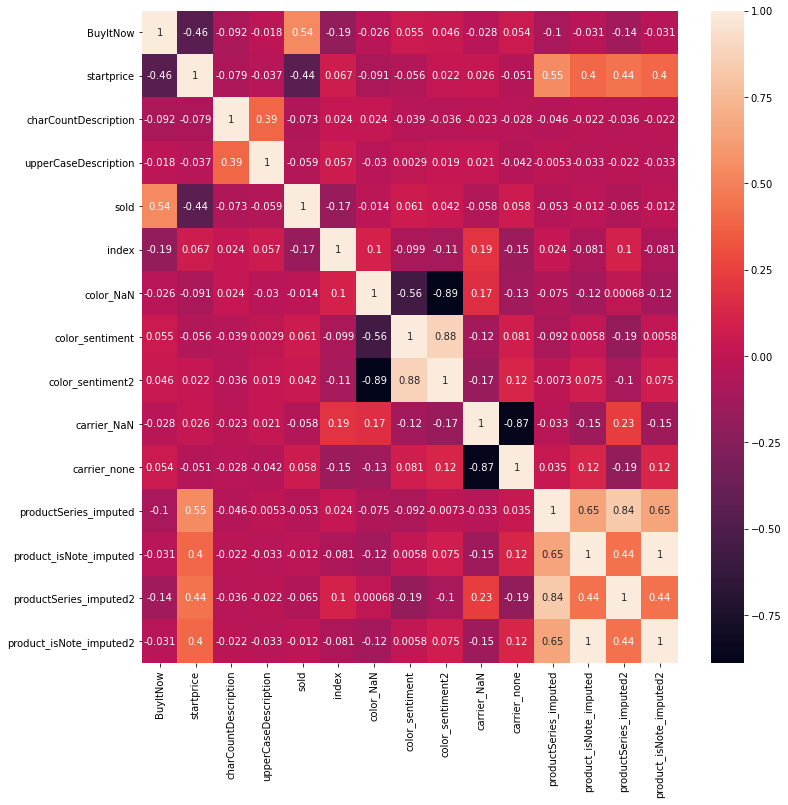

In [64]:
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(), annot=True)

In [203]:
df.to_csv('./data/galaxy_noise.csv', encoding='utf-8-sig')